In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
import datetime
from newsapi import NewsApiClient

NEWS_API_KEY = 'cf46460e66c44c80bb2aac1a7701e764'  # Replace with your key
newsapi = NewsApiClient(api_key=NEWS_API_KEY)


In [70]:
def get_stock_news(ticker):
    company_name = ticker.upper()
    news = newsapi.get_everything(q=company_name, language='en', sort_by='publishedAt', page_size=5)

    print(f"\n📰 Latest News Headlines for {company_name}:\n")
    for i, article in enumerate(news['articles']):
        print(f"{i+1}. {article['title']}")
        print(f"   {article['url']}\n")


In [73]:
get_stock_news('AAPL')

start = input("Enter start date (YYYY-MM-DD): ") or "2020-01-01"
end = input("Enter end date (YYYY-MM-DD): ") or "2025-04-10"

try:
    start = pd.to_datetime(start)
    end = pd.to_datetime(end)
    if start >= end:
        raise ValueError("Start date must be before end date.")
except Exception as e:
    print(f"Invalid date input: {e}")
    raise SystemExit

df = yf.download('AAPL', start=start, end=end)
df = df[['Close']]


📰 Latest News Headlines for AAPL:

1. AmazonスマイルSALEでBuffaloやIODATA、KIOXIA、Samsung、SanDisk、WDなどのSSDやHDDが特選タイムセール中。
   https://applech2.com/archives/20250530-amazon-smile-sale-ssd.html

2. Berkeley Capital Partners LLC Has $4.38 Million Position in Apple Inc. (NASDAQ:AAPL)
   https://www.etfdailynews.com/2025/05/30/berkeley-capital-partners-llc-has-4-38-million-position-in-apple-inc-nasdaqaapl/

3. Investment House LLC Has $139.09 Million Stock Holdings in Apple Inc. (NASDAQ:AAPL)
   https://www.etfdailynews.com/2025/05/30/investment-house-llc-has-139-09-million-stock-holdings-in-apple-inc-nasdaqaapl/

4. Arvest Investments Inc. Has $4.43 Million Position in Apple Inc. (NASDAQ:AAPL)
   https://www.etfdailynews.com/2025/05/30/arvest-investments-inc-has-4-43-million-position-in-apple-inc-nasdaqaapl/

5. Apple Inc. (NASDAQ:AAPL) Shares Acquired by Fiduciary Group LLC
   https://www.etfdailynews.com/2025/05/30/apple-inc-nasdaqaapl-shares-acquired-by-fiduciary-group-llc/



Enter start date (YYYY-MM-DD):  2010-01-01
Enter end date (YYYY-MM-DD):  2025-04-30


[*********************100%***********************]  1 of 1 completed


In [74]:
ma100 = df['Close'].rolling(window=200).mean()

In [75]:
data_training = df[:int(len(df) * 0.70)]
data_testing = df[int(len(df) * 0.70):]

In [76]:
scaler = MinMaxScaler(feature_range=(0,1))
training_scaled = scaler.fit_transform(data_training)

In [77]:
x_train = []
y_train = []
for i in range(100, len(training_scaled)):
    x_train.append(training_scaled[i-100:i])
    y_train.append(training_scaled[i])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)

In [78]:
model = Sequential()
model.add(Input(shape=(100, 1)))  # Separate Input layer
model.add(LSTM(units=60, activation='relu', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=60, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                       │ (None, 100, 60)             │          14,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 100, 60)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_13 (LSTM)                       │ (None, 60)                  │          29,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 60)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              61 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 43,981 (171.80 KB)

 Trainable params: 43,981 (171.80 KB)

 Non-trainable params: 0 (0.00 B)

In [79]:
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_squared_error')

early_stop = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

model.fit(x_train, y_train, epochs=100, callbacks=[early_stop])

Epoch 1/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 15s 107ms/step - loss: 0.0302
Epoch 2/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 7s 82ms/step - loss: 0.0011
Epoch 3/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 11s 93ms/step - loss: 0.0012
Epoch 4/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 7s 83ms/step - loss: 0.0010
Epoch 5/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - loss: 9.4035e-04
Epoch 6/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step - loss: 0.0012
Epoch 7/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - loss: 8.4690e-04
Epoch 8/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - loss: 9.2834e-04
Epoch 9/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 7s 86ms/step - loss: 9.2324e-04
Epoch 10/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 7s 85ms/step - loss: 7.8330e-04
Epoch 11/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - loss: 9.4054e-04
Epoch 12/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 7s 86ms/step - loss: 6.8902e-04
Epoch 13/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - loss: 7.5902e-04
Epoch 14/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - loss: 6.9747e-04
Epoch 15/100
82/82

In [80]:
model.save('Stock_Predictor.keras')

In [81]:
past_100_days = data_training.tail(100)
final_df = pd.concat([past_100_days, data_testing], ignore_index=True)
input_data = scaler.transform(final_df)

x_test = []
y_test = []

for i in range(100, input_data.shape[0]):
    x_test.append(input_data[i-100:i])
    y_test.append(input_data[i])

x_test, y_test = np.array(x_test), np.array(y_test)

x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)


In [82]:
y_pred = model.predict(x_test)

y_predicted = scaler.inverse_transform(y_pred)
y_original = scaler.inverse_transform(y_test)



rmse = np.sqrt(mean_squared_error(y_original, y_predicted))
mae = mean_absolute_error(y_original, y_predicted)
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")



37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step
RMSE: 7.768425370642776
MAE: 5.826760822055458


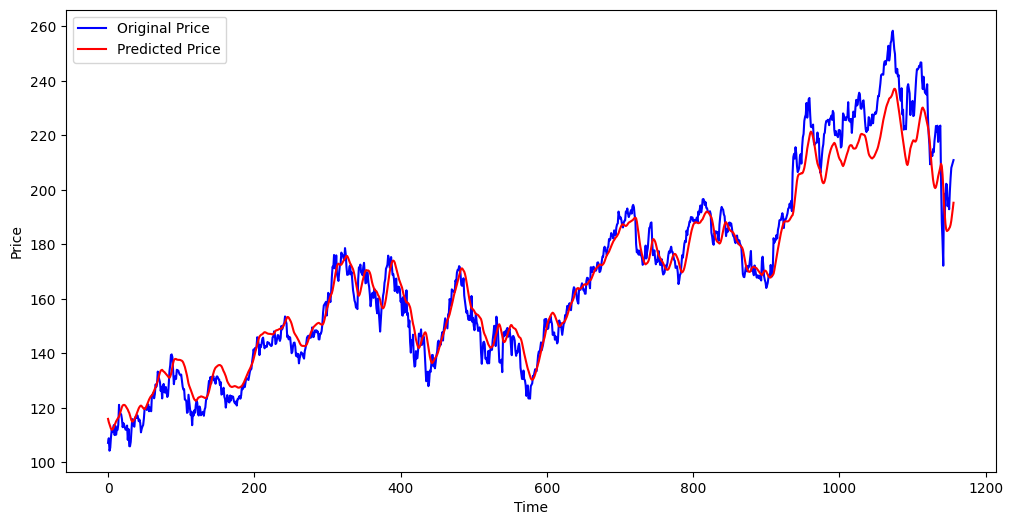

In [83]:
plt.figure(figsize=(12,6))
plt.plot(y_original, 'b', label='Original Price')
plt.plot(y_predicted, 'r', label='Predicted Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()
